In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import seaborn as sns

In [94]:
# Data from the table
categories = ['Characters', 'Themes', 'Scenes']
both = [29.11, 8.45, 86.95]
sparknotes_only = [1.08, 1.26, 8.6]
story_ribbons_only = [69.81, 90.29, 4.44]

In [95]:
data = np.array([both, sparknotes_only, story_ribbons_only]).T  # Transpose to match categories
labels = ['Both', 'SparkNotes Only', 'Story Ribbons Only']
colors = ['#b8e0d2', '#eac4d5', '#809bce']  # Colors for the segments

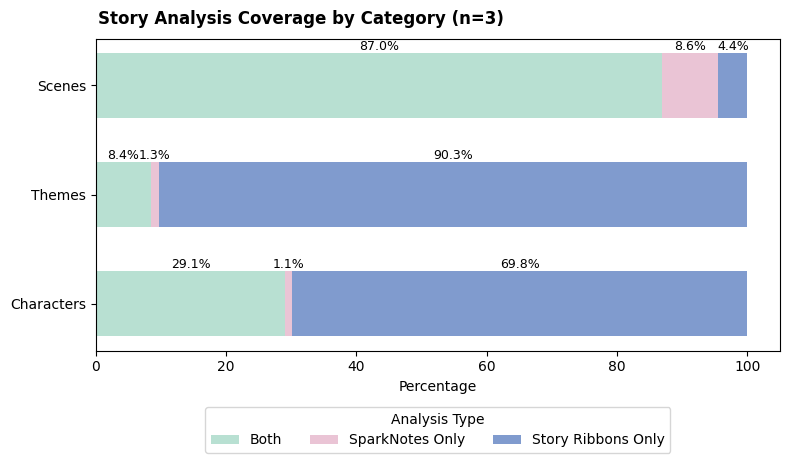

In [96]:
# Adjust the annotation to place data labels above each segment
fig, ax = plt.subplots(figsize=(8, 5))
left = np.zeros(len(categories))
width = 0.6  # Bar thickness

# Create the stacked bars
for i, (label, color) in enumerate(zip(labels, colors)):
    ax.barh(y, data[:, i], height=width, label=label, color=color, left=left)
    left += data[:, i]

# Add labels and title
ax.set_yticks(y)
ax.set_yticklabels(categories)
ax.set_xlabel('Percentage')
ax.set_title('Story Analysis Coverage by Category (n=3)', fontweight='bold', y=1.02, x=0.3)
ax.legend(title='Analysis Type', loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)  # Legend below the plot

# Annotate segments with values above each segment
left = np.zeros(len(categories))  # Reset left positions
for i in range(len(categories)):
    for j in range(len(labels)):
        value = data[i, j]
        if value > 0:
            ax.text(left[i] + value / 2, i + width / 2,  # Adjust label position
                    f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
        left[i] += value  # Update the left position

fig.tight_layout()
plt.show()


In [97]:
# read in data from data/percent_data.csv

df = pd.read_csv('data/percent_data.csv')

df.head()

,Group,Category,Subcategory,Part of book,Percent
0,All,Scene,Divider,Beginning,39.40%
1,All,Scene,Transition - topical,Beginning,25.53%
2,All,Scene,Transition - character(s) enter or leave,Beginning,8.77%
3,All,Scene,Transition - time passes,Beginning,8.93%
4,All,Scene,Transition - location change,Beginning,15.58%


In [98]:
# remove "%" in Percent column and convert to float
df['Percent'] = df['Percent'].str.replace('%', '').astype(float)

df.head()

,Group,Category,Subcategory,Part of book,Percent
0,All,Scene,Divider,Beginning,39.40
1,All,Scene,Transition - topical,Beginning,25.53
2,All,Scene,Transition - character(s) enter or leave,Beginning,8.77
3,All,Scene,Transition - time passes,Beginning,8.93
4,All,Scene,Transition - location change,Beginning,15.58


In [197]:
# filter out group = "All"
df = df[df['Group'] != 'All']

In [99]:
# Define a function to run ANOVA for each subcategory
def run_anova(df, category, subcategory, comparison="Group"):
    # Filter data for the specific category and subcategory
    data = df[(df["Category"] == category) & (df["Subcategory"] == subcategory)]
    
    # Group data by the Group column
    if comparison == "Group":
        wellknown = data[data["Group"] == "Well-known"]["Percent"]
        lesserknown = data[data["Group"] == "Lesser known"]["Percent"]
        llm = data[data["Group"] == "LLM-generated"]["Percent"]

        # print("Sample sizes:")
        # print(f"Well-known: {len(wellknown)}")
        # print(f"Lesser-known: {len(lesserknown)}")
        # print(f"LLM-generated: {len(llm)}")
        
        # Run ANOVA
        f_stat, p_value = f_oneway(wellknown, lesserknown, llm)
    else: # comparison == "Part of book"
        beginning = data[data["Part of book"] == "Beginning"]["Percent"]
        middle = data[data["Part of book"] == "Middle"]["Percent"]
        end = data[data["Part of book"] == "End"]["Percent"]

        # print("Sample sizes:")
        # print(f"Beginning: {len(beginning)}")
        # print(f"Middle: {len(middle)}")
        # print(f"End: {len(end)}")

        # Run ANOVA
        f_stat, p_value = f_oneway(beginning, middle, end)
    return f_stat, p_value

In [198]:
comparisons = ["Group", "Part of book"]

# Get unique categories
categories = df["Category"].unique()
subcategories_by_category = {}
anova_results = {}
for comparison in comparisons:
    anova_results[comparison] = {}
for category in categories:
    subcategories_by_category[category] = df[df["Category"] == category]["Subcategory"].unique()
    for comp in comparisons:
        anova_results[comp][category] = {}

# Run ANOVA for each subcategory and store results
for comp in comparisons:
    print("*" * 40)
    print(f"Comparison: {comp}")
    print("*" * 40)
    for category in categories:
        print(f"Category: {category}")
        for subcategory in subcategories_by_category[category]:
            print(f"\tSubcategory: {subcategory}")
            f_stat, p_value = run_anova(df, category, subcategory, comparison=comp)
            anova_results[comp][category][subcategory] = {"F-statistic": f_stat, "P-value": p_value}

****************************************
Comparison: Group
****************************************
Category: Scene
	Subcategory: Divider
	Subcategory: Transition - topical
	Subcategory: Transition - character(s) enter or leave
	Subcategory: Transition - time passes
	Subcategory: Transition - location change
	Subcategory: Transition - description <--> dialogue
Category: Character
	Subcategory: Phsyically in scene
	Subcategory: Mentioned only
	Subcategory: Mislabelled/incorrect
	Subcategory: Missing
Category: Quote
	Subcategory: Accurate, spoken
	Subcategory: Paraphrased
	Subcategory: Describes character
	Subcategory: Mismatch b/t quote + emotion
	Subcategory: Incorrect emotion
	Subcategory: Incorrect quote
****************************************
Comparison: Part of book
****************************************
Category: Scene
	Subcategory: Divider
	Subcategory: Transition - topical
	Subcategory: Transition - character(s) enter or leave
	Subcategory: Transition - time passes
	Subcatego

In [199]:
# Print ANOVA results for each category and subcategory
for comp in anova_results:
    print("*" * 40)
    print(f"Comparison: {comp}")
    print("*" * 40)
    for category in anova_results[comp]:
        print(f"Category: {category}")
        for subcategory in anova_results[comp][category]:
            print(f"\tSubcategory: {subcategory}")
            print(f"\t\tF-statistic: {anova_results[comp][category][subcategory]['F-statistic']:.2f}")
            print(f"\t\tP-value: {anova_results[comp][category][subcategory]['P-value']:.4f}")

****************************************
Comparison: Group
****************************************
Category: Scene
	Subcategory: Divider
		F-statistic: 2.98
		P-value: 0.1265
	Subcategory: Transition - topical
		F-statistic: 5.45
		P-value: 0.0447
	Subcategory: Transition - character(s) enter or leave
		F-statistic: 0.20
		P-value: 0.8233
	Subcategory: Transition - time passes
		F-statistic: 22.64
		P-value: 0.0016
	Subcategory: Transition - location change
		F-statistic: 0.99
		P-value: 0.4256
	Subcategory: Transition - description <--> dialogue
		F-statistic: 0.74
		P-value: 0.5175
Category: Character
	Subcategory: Phsyically in scene
		F-statistic: 3.39
		P-value: 0.1035
	Subcategory: Mentioned only
		F-statistic: 2.18
		P-value: 0.1948
	Subcategory: Mislabelled/incorrect
		F-statistic: 0.29
		P-value: 0.7579
	Subcategory: Missing
		F-statistic: 1.41
		P-value: 0.3157
Category: Quote
	Subcategory: Accurate, spoken
		F-statistic: 3.40
		P-value: 0.1030
	Subcategory: Paraphrased
		F-

In [200]:
# filter data for significant p-values (< 0.05)
significant_results = {}
for comp in anova_results:
    significant_results[comp] = {}
    for category in anova_results[comp]:
        significant_results[comp][category] = {}
        for subcategory in anova_results[comp][category]:
            if anova_results[comp][category][subcategory]["P-value"] < 0.05:
                significant_results[comp][category][subcategory] = anova_results[comp][category][subcategory]

# Print significant results
for comp in significant_results:
    print("*" * 40)
    print(f"Comparison: {comp}")
    print("*" * 40)
    for category in significant_results[comp]:
        print(f"Category: {category}")
        for subcategory in significant_results[comp][category]:
            print(f"\tSubcategory: {subcategory}")
            print(f"\t\tF-statistic: {significant_results[comp][category][subcategory]['F-statistic']:.2f}")
            print(f"\t\tP-value: {significant_results[comp][category][subcategory]['P-value']:.4f}")

****************************************
Comparison: Group
****************************************
Category: Scene
	Subcategory: Transition - topical
		F-statistic: 5.45
		P-value: 0.0447
	Subcategory: Transition - time passes
		F-statistic: 22.64
		P-value: 0.0016
Category: Character
Category: Quote
	Subcategory: Mismatch b/t quote + emotion
		F-statistic: 11.86
		P-value: 0.0082
	Subcategory: Incorrect quote
		F-statistic: 7.25
		P-value: 0.0250
****************************************
Comparison: Part of book
****************************************
Category: Scene
	Subcategory: Transition - character(s) enter or leave
		F-statistic: 7.95
		P-value: 0.0206
Category: Character
Category: Quote


In [201]:
# Function to run Tukey's HSD post-hoc test for significant ANOVA results
def run_post_hoc(df, category, subcategory, comparison="Group"):
    # Filter data for the specific subcategory
    data = df[(df["Category"] == category) & (df["Subcategory"] == subcategory)]
    
    # Prepare data for Tukey's HSD
    tukey_data = data[["Percent", comparison]].copy()
    
    # Run Tukey's HSD
    tukey = pairwise_tukeyhsd(endog=tukey_data["Percent"], 
                              groups=tukey_data["Group"] if comparison == "Group" else tukey_data["Part of book"],
                              alpha=0.05)
    return tukey.summary()

In [202]:
# run Tukey's HSD for significant results
tukey_results = {}
for comp in significant_results:
    tukey_results[comp] = {}
    for category in significant_results[comp]:
        tukey_results[comp][category] = {}
        for subcategory in significant_results[comp][category]:
            tukey_results[comp][category][subcategory] = run_post_hoc(df, category, subcategory, comparison=comp)

In [203]:
# Function to format and display Tukey's HSD results as a DataFrame
def tukey_to_dataframe(tukey_summary, category, subcategory, comparison="Group"):
    # Convert Tukey's summary table to a readable DataFrame
    tukey_df = pd.DataFrame(data=tukey_summary.data[1:], columns=tukey_summary.data[0])
    tukey_df["category"] = category
    tukey_df["subcategory"] = subcategory
    tukey_df["comparison"] = comparison
    return tukey_df

In [204]:
# convert tukey results to dfs and filter data for reject = True
tukey_dfs = []
for comp in tukey_results:
    for category in tukey_results[comp]:
        for subcategory in tukey_results[comp][category]:
            tukey_df = tukey_to_dataframe(tukey_results[comp][category][subcategory], category, subcategory, comparison=comp)
            tukey_dfs.append(tukey_df[tukey_df["reject"] == True])

# Concatenate all Tukey's HSD results into a single DataFrame
tukey_results_df = pd.concat(tukey_dfs)

# Display the Tukey's HSD results
tukey_results_df

,group1,group2,meandiff,p-adj,lower,upper,reject,category,subcategory,comparison
1,LLM-generated,Well-known,22.7733,0.0418,1.0345,44.5122,True,Scene,Transition - topical,Group
0,LLM-generated,Lesser known,-17.6533,0.0412,-34.4439,-0.8628,True,Scene,Transition - time passes,Group
1,LLM-generated,Well-known,-36.8167,0.0013,-53.6072,-20.0261,True,Scene,Transition - time passes,Group
2,Lesser known,Well-known,-19.1633,0.0296,-35.9539,-2.3728,True,Scene,Transition - time passes,Group
0,LLM-generated,Lesser known,2.7667,0.0449,0.0762,5.4572,True,Quote,Mismatch b/t quote + emotion,Group
1,LLM-generated,Well-known,4.2000,0.0072,1.5095,6.8905,True,Quote,Mismatch b/t quote + emotion,Group
1,LLM-generated,Well-known,-27.2633,0.0329,-51.7637,-2.7630,True,Quote,Incorrect quote,Group
2,Lesser known,Well-known,-25.3100,0.0442,-49.8103,-0.8097,True,Quote,Incorrect quote,Group
2,End,Middle,13.4400,0.0171,3.0823,23.7977,True,Scene,Transition - character(s) enter or leave,Part of book


In [205]:
# get mean values for each category and subcategory
mean_values_group = df.groupby(["Group", "Category", "Subcategory"])["Percent"].mean().reset_index()
mean_values_part = df.groupby(["Part of book", "Category", "Subcategory"])["Percent"].mean().reset_index()


In [206]:
mean_values_group

,Group,Category,Subcategory,Percent
0,LLM-generated,Character,Mentioned only,0.000000
1,LLM-generated,Character,Mislabelled/incorrect,1.390000
2,LLM-generated,Character,Missing,0.693333
3,LLM-generated,Character,Phsyically in scene,97.916667
4,LLM-generated,Quote,"Accurate, spoken",61.320000
5,LLM-generated,Quote,Describes character,5.613333
6,LLM-generated,Quote,Incorrect emotion,0.000000
7,LLM-generated,Quote,Incorrect quote,30.333333
8,LLM-generated,Quote,Mismatch b/t quote + emotion,1.446667
9,LLM-generated,Quote,Paraphrased,1.283333


/var/folders/mz/w02bb_0922n2ldj_7cz0m8b00000gp/T/ipykernel_87305/594174711.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # Adjust layout to fit the legend


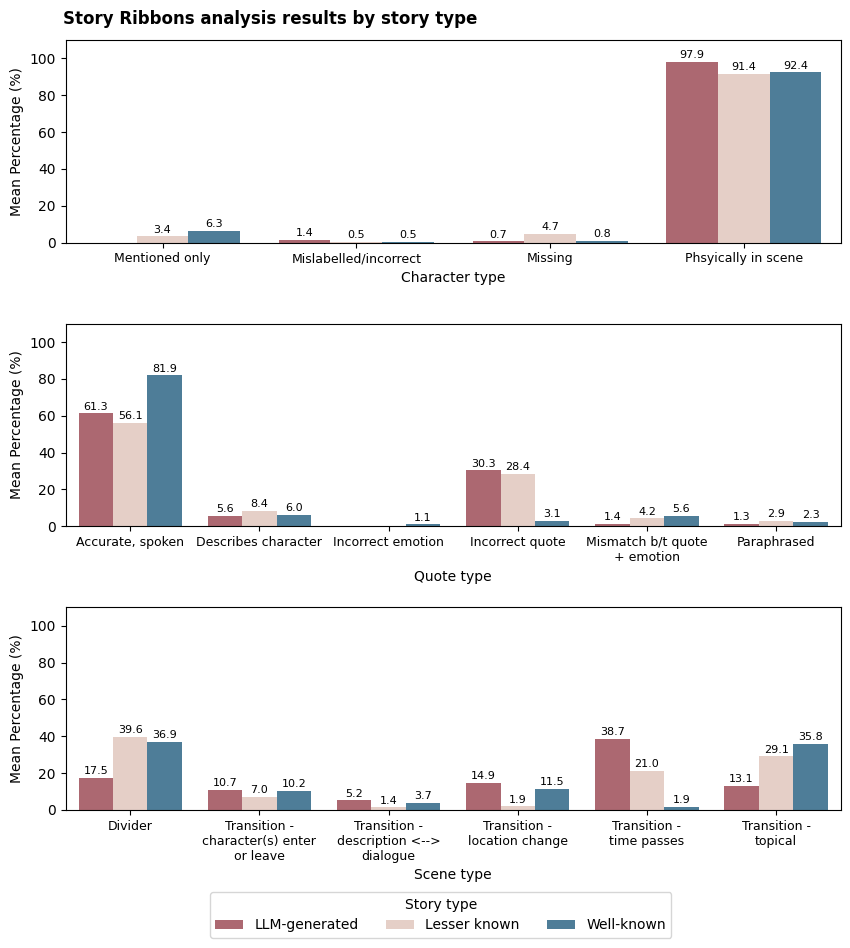

In [213]:
# Define a function to wrap x-axis labels
def wrap_label(label, n=3):
    words = label.split()
    wrapped = '\n'.join([' '.join(words[i:i + n]) for i in range(0, len(words), n)])
    return wrapped

# Define a custom color palette as a dictionary
custom_colors = {
    "Lesser known": "#eacdc2",
    "LLM-generated": "#b75d69",
    "Well-known": "#4281a4",

}

# Plot mean values for each category and subcategory
fig, axes = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.4})

for i, category in enumerate(mean_values_group["Category"].unique()):
    data = mean_values_group[mean_values_group["Category"] == category]
    ax = axes[i]
    
    # Use custom color palette
    barplot = sns.barplot(
        x="Subcategory", y="Percent", hue="Group", data=data, ax=ax, palette=custom_colors
    )
    
    ax.set_ylabel("Mean Percentage (%)")
    ax.set_xlabel(f"{category} type")
    ax.set_ylim(0, 110)

    # Add labels above each bar
    for bar in ax.patches:
        height = bar.get_height()
        if not np.isnan(height) and height != 0:  # Only add label if height is not NaN
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # x-coordinate
                height + 1,  # y-coordinate slightly above the bar
                f'{height:.1f}',  # Format the label
                ha='center', va='bottom', fontsize=8
            )
    
    # Suppress individual legends
    ax.legend_.remove()

    # Apply wrapped labels to x-axis
    n = 2 if category == "Scene" else 3
    wrapped_labels = [wrap_label(label, n=n) for label in data["Subcategory"].unique()]
    ax.set_xticks(range(len(wrapped_labels)))
    ax.set_xticklabels(wrapped_labels, rotation=0, ha="center", fontsize=9)

# Add a single legend for all plots
handles, labels = barplot.get_legend_handles_labels()
fig.legend(handles, labels, title="Story type", loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.025))

# Add main title
fig.suptitle("Story Ribbons analysis results by story type", fontweight='bold', y=0.91, x=0.33)

plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # Adjust layout to fit the legend
plt.show()

In [211]:
mean_values_part

,Part of book,Category,Subcategory,Percent
0,Beginning,Character,Mentioned only,3.380000
1,Beginning,Character,Mislabelled/incorrect,0.543333
2,Beginning,Character,Missing,0.986667
3,Beginning,Character,Phsyically in scene,95.090000
4,Beginning,Quote,"Accurate, spoken",61.200000
5,Beginning,Quote,Describes character,9.436667
6,Beginning,Quote,Incorrect emotion,1.056667
7,Beginning,Quote,Incorrect quote,21.883333
8,Beginning,Quote,Mismatch b/t quote + emotion,4.360000
9,Beginning,Quote,Paraphrased,2.063333


/var/folders/mz/w02bb_0922n2ldj_7cz0m8b00000gp/T/ipykernel_87305/4217329731.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # Adjust layout to fit the legend


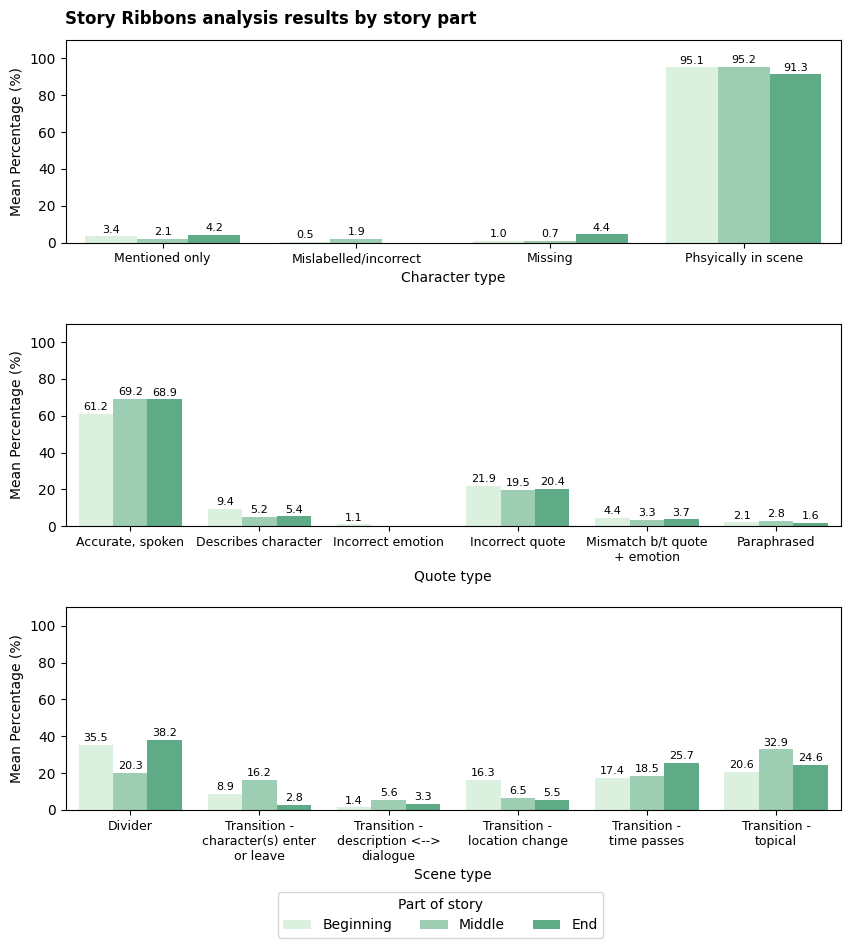

In [214]:
# Define a function to wrap x-axis labels
def wrap_label(label, n=3):
    words = label.split()
    wrapped = '\n'.join([' '.join(words[i:i + n]) for i in range(0, len(words), n)])
    return wrapped

# Define a custom color palette as a dictionary
custom_colors = {
    "Beginning": "#d8f3dc",
    "Middle": "#95d5b2",
    "End": "#52b788",
}

# Define the desired order for the legend and bars
legend_order = ["Beginning", "Middle", "End"]

# Plot mean values for each category and subcategory
fig, axes = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.4})

for i, category in enumerate(mean_values_part["Category"].unique()):
    data = mean_values_part[mean_values_part["Category"] == category]
    ax = axes[i]
    
    # Use custom color palette and set bar order with hue_order
    barplot = sns.barplot(
        x="Subcategory", 
        y="Percent", 
        hue="Part of book", 
        data=data, 
        ax=ax, 
        palette=custom_colors,
        hue_order=legend_order  # Ensures the order of bars matches the legend
    )
    
    ax.set_ylabel("Mean Percentage (%)")
    ax.set_xlabel(f"{category} type")
    ax.set_ylim(0, 110)

    # Add labels above each bar
    for bar in ax.patches:
        height = bar.get_height()
        if not np.isnan(height) and height != 0:  # Only add label if height is not NaN
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # x-coordinate
                height + 1,  # y-coordinate slightly above the bar
                f'{height:.1f}',  # Format the label
                ha='center', va='bottom', fontsize=8
            )
    
    # Suppress individual legends
    ax.legend_.remove()

    # Apply wrapped labels to x-axis
    n = 2 if category == "Scene" else 3
    wrapped_labels = [wrap_label(label, n=n) for label in data["Subcategory"].unique()]
    ax.set_xticks(range(len(wrapped_labels)))
    ax.set_xticklabels(wrapped_labels, rotation=0, ha="center", fontsize=9)

# Add a single legend for all plots
handles, labels = barplot.get_legend_handles_labels()

# Reorder handles and labels based on the desired legend order
ordered_handles_labels = sorted(zip(handles, labels), key=lambda x: legend_order.index(x[1]))
ordered_handles, ordered_labels = zip(*ordered_handles_labels)

fig.legend(
    ordered_handles,
    ordered_labels,
    title="Part of story",
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.025),
)

# Add main title
fig.suptitle("Story Ribbons analysis results by story part", fontweight='bold', y=0.91, x=0.33)

plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # Adjust layout to fit the legend
plt.show()